# **Projet de modélisation statistique**
*Tony Lauze - Amine Zarig*

## **1) Importation des données et statistiques descriptives**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Seminaire-modelisation-2A-ENSAE')

In [3]:
path = 'GWMF_Dataset.DAT'

In [4]:
df = pd.read_csv(path)
print(df.columns)
df = df[['abs_gwmf', 'tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd', 'balloon']]
df.columns

Index(['Unnamed: 0', 'tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd',
       'balloon', 'abs_gwmf'],
      dtype='object')


Index(['abs_gwmf', 'tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd',
       'balloon'],
      dtype='object')

In [8]:
#création des sous-dataframes par ballon
dict_balloon = {}
for i in range (1,8+1): 
    dict_balloon[i]= df[df['balloon']==i]

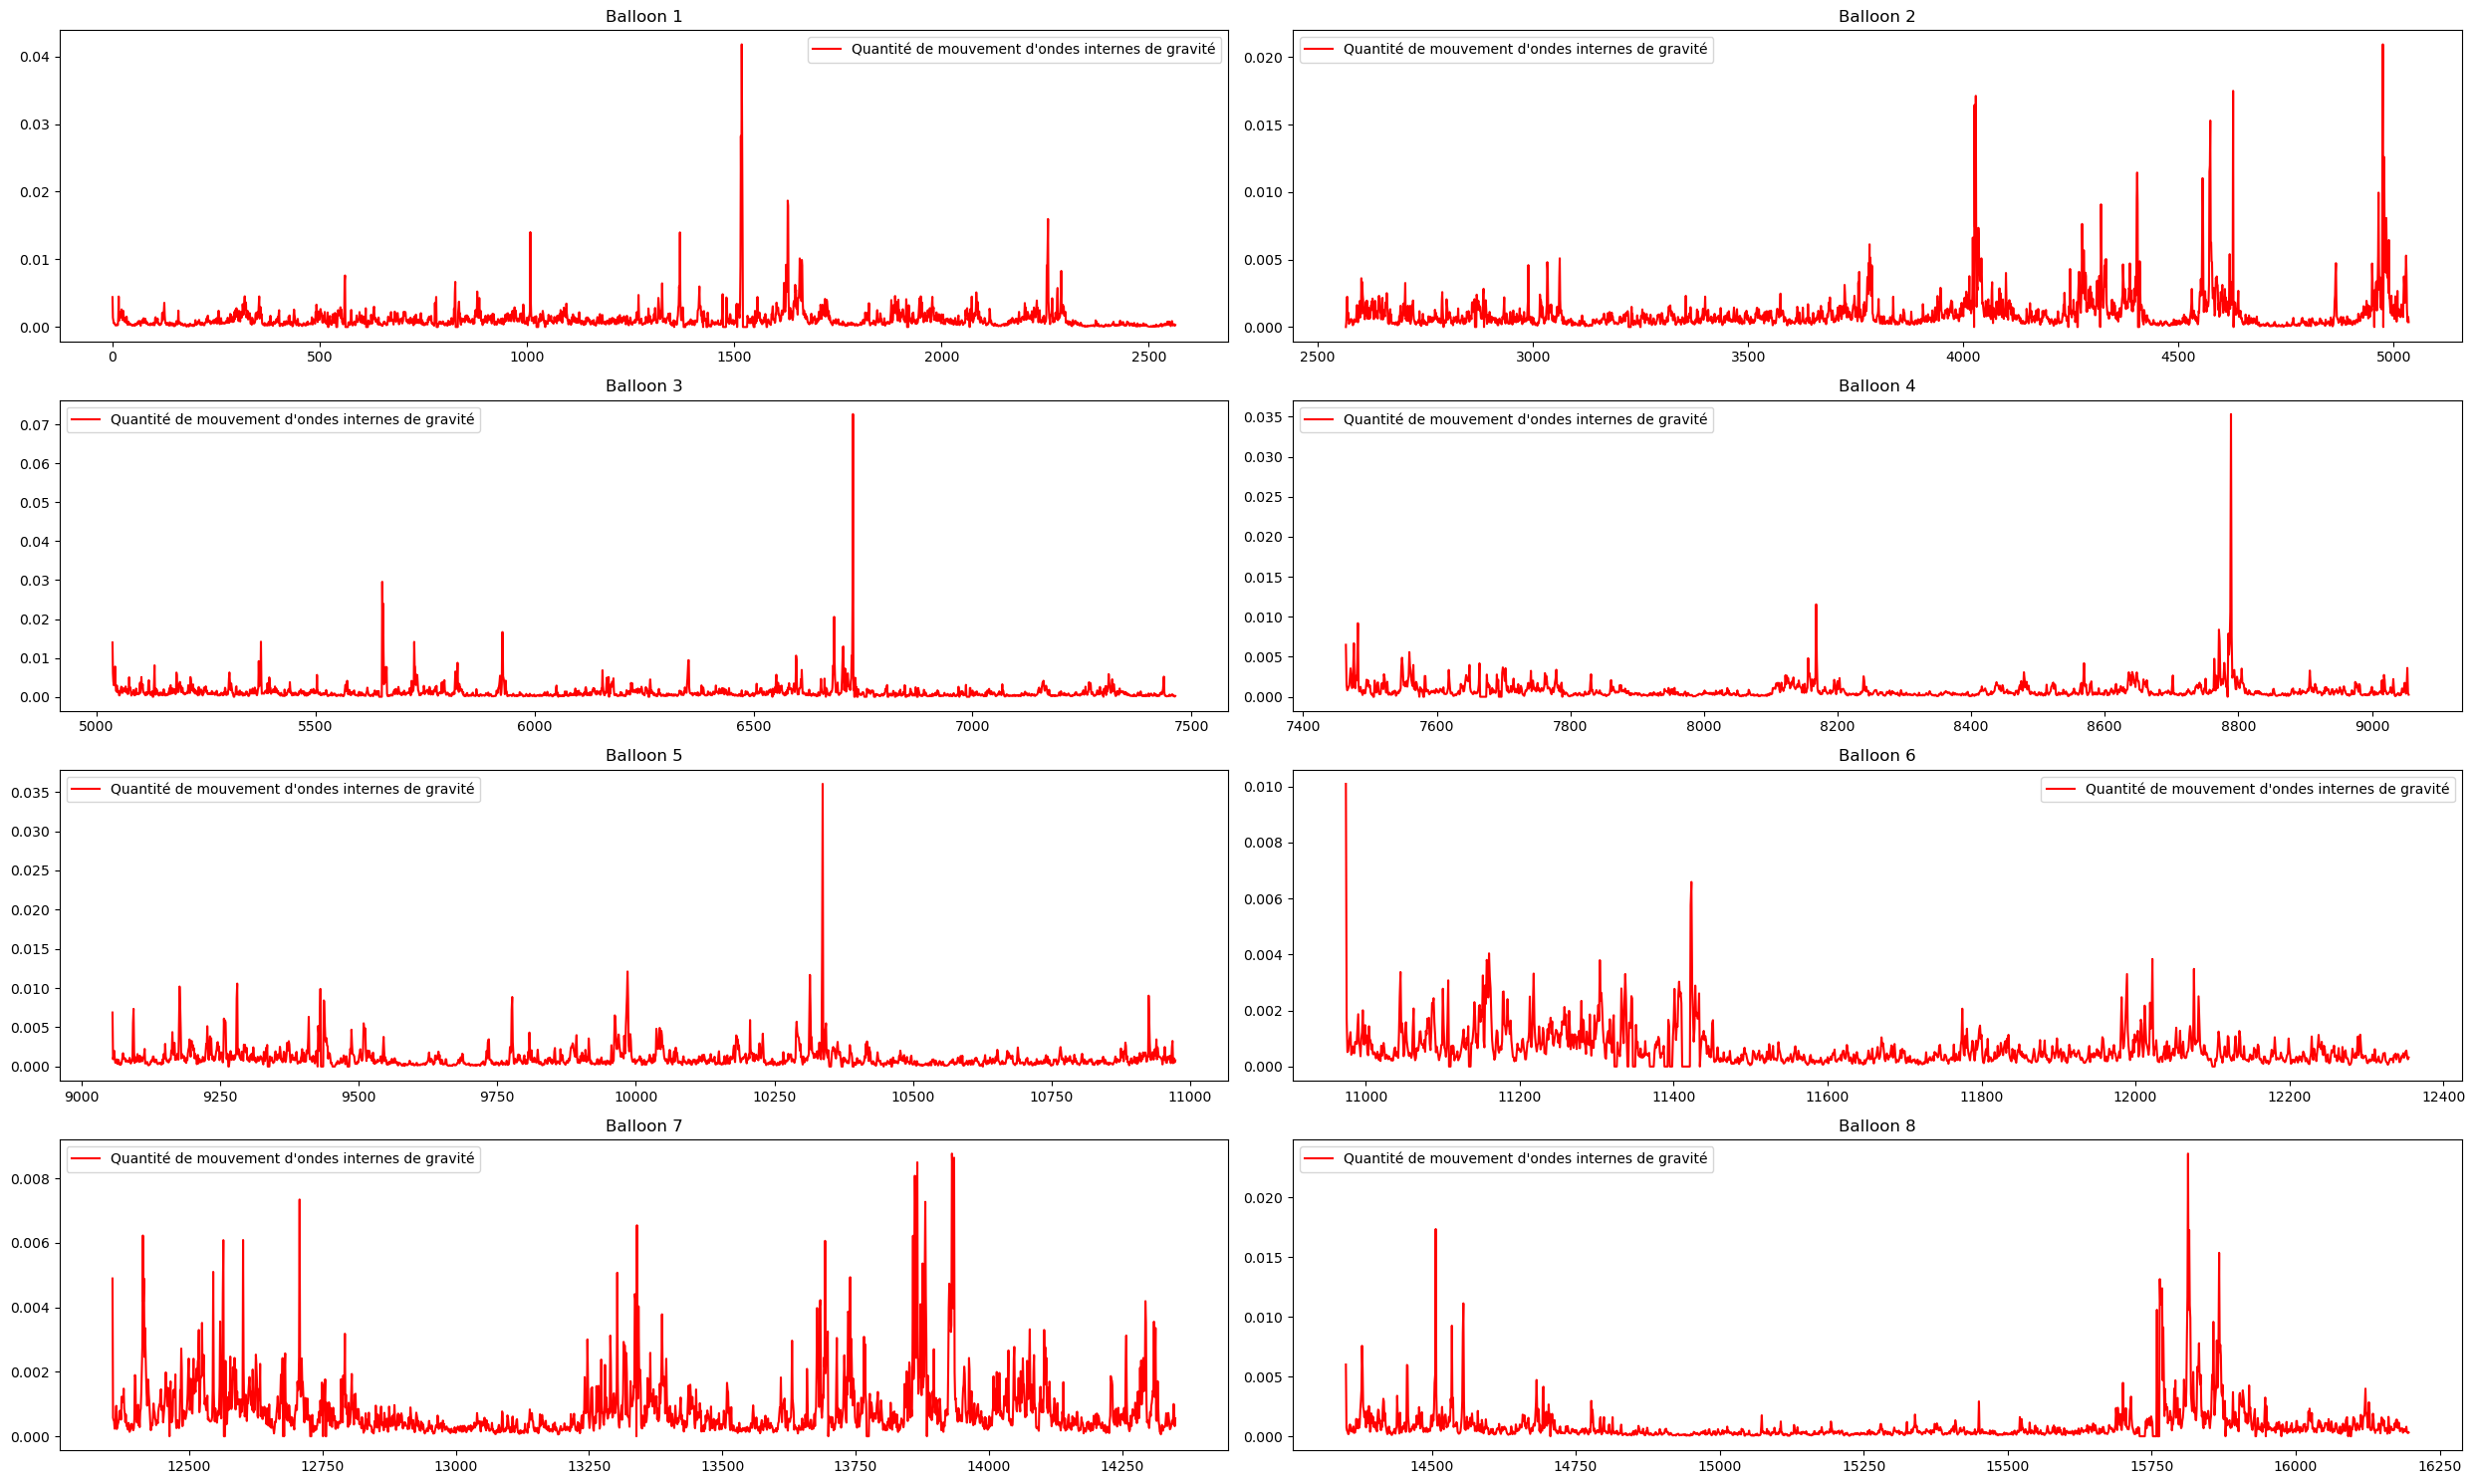

In [10]:
#graphique de l'évolution de la variable cible selon chaque ballon
fig, axs = plt.subplots(4, 2, figsize=(25, 15))

for i in range(8):
    row, col = i // 2, i % 2  # Calculate the correct row and column for subplots
    axs[row, col].plot(dict_balloon[i+1]['abs_gwmf'], color='r', label="Quantité de mouvement d'ondes internes de gravité")
    axs[row, col].legend()
    axs[row, col].set_title("Balloon {}".format(i+1))

plt.tight_layout()
plt.show()

In [11]:
df

,abs_gwmf,tp,lnsp,temp19,temp9,temp2,temp0,u19,u9,u2,u0,v19,v9,v2,v0,sza,tp_mean,tp_sd,balloon
0,0.004419,1.283398e-05,11.520824,198.78241,246.25427,288.58835,300.20900,0.221898,-1.062763,-0.763388,-1.085501,8.394401,1.220549,1.909220,1.536844,131.556030,0.000044,0.000043,1
1,0.001380,1.818147e-05,11.521313,198.87085,246.25975,288.65485,300.28513,0.634961,-0.841705,-1.202977,-1.242136,8.366734,1.351404,1.903986,1.593673,118.018845,0.000039,0.000047,1
2,0.000965,6.938894e-18,11.521270,198.46156,246.25015,289.30478,300.28168,2.032046,-0.680017,-3.652297,-1.132238,8.040718,1.461322,1.232512,1.355890,104.009210,0.000026,0.000041,1
3,0.000584,6.938894e-18,11.521748,198.43893,246.24603,289.34730,300.28920,2.560058,-0.566331,-4.113360,-1.278768,8.087078,1.756681,1.065766,1.406737,89.609990,0.000035,0.000044,1
4,0.000638,6.938894e-18,11.522120,198.35872,246.30430,289.43370,300.46335,2.608059,-0.666122,-4.532739,-1.613513,7.729657,1.850896,0.691146,1.361872,75.231340,0.000032,0.000043,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,0.000798,3.055840e-04,11.522435,200.77188,249.31682,288.74173,299.45230,10.564401,0.821343,0.256646,-1.590808,-2.692086,4.720400,-2.920836,-2.906454,102.785286,0.000805,0.000552,8
16193,0.000325,5.037100e-05,11.522701,201.24982,249.08050,288.64250,299.23798,10.342991,1.573934,-1.667996,-1.259708,-3.441347,4.325222,-2.681127,-2.235269,87.666890,0.000577,0.000512,8
16194,0.000338,1.027568e-03,11.523268,201.33313,248.86464,288.97880,299.61140,10.005797,1.388072,-1.777686,-1.813233,-2.448952,4.216326,-2.368821,-1.684623,72.810875,0.000865,0.000796,8
16195,0.000267,5.339325e-04,11.523916,201.39827,248.74799,289.23178,300.07413,9.964156,-0.865639,-5.335481,-3.278805,-1.506554,3.125993,-0.807973,0.530288,57.962414,0.000635,0.000738,8


## **2) Modélisation**

In [163]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

In [169]:
"""MODELE DE RANDOM FOREST"""
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
list_errors_rf = []
dict_predictions_rf = dict()
dict_importance_var_rf = dict()

In [139]:
"""MODELE LINEAIRE"""
model_lr = LinearRegression()
list_errors_lr = []
dict_predictions_lr = dict()
dict_importance_var_lr = dict()

In [140]:
"""MODELE LASSO"""
model_lasso = Lasso()
list_errors_lasso = []
dict_predictions_lasso = dict()
dict_importance_var_lasso = dict()

In [141]:
"""MODELE ADABOOST"""
from sklearn.ensemble import AdaBoostRegressor
model_adaboost = AdaBoostRegressor(n_estimators=100, random_state=42)
list_errors_adaboost = []
dict_predictions_adaboost = dict()
dict_importance_var_adaboost = dict()

In [142]:
"""MODELE XGBOOST"""
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
list_errors_xgb = []
dict_predictions_xgb = dict()
dict_importance_var_xgb = dict()

In [143]:
"""Fonction qui, à partir d'un modèle, entraine et test ballon par ballon, et enregistre les performances du modèle"""

def train_test_and_save_performance(model, list_errors, dict_predictions, dict_importance_var, normaliser=False, arbre=True):

    #boucle qui passe ballon par ballon
    for i in range(1, 9):
        
        # Pour chaque ballon on constitue l'ensemble de test et d'entrainement
        test_data = df.loc[df['balloon']==i]
        train_data = df.loc[df['balloon']!=i] 
        
        # Séparer variable explicatives et variables de test
        X_train = train_data.drop(['abs_gwmf', 'balloon'], axis=1)
        X_train = sm.add_constant(X_train)
        y_train = train_data['abs_gwmf']
        
        X_test = test_data.drop(['abs_gwmf', 'balloon'], axis=1)
        X_test = sm.add_constant(X_test)
        y_test = test_data['abs_gwmf']
        
        # Normalisation
        if normaliser==True:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)    
            X_test = scaler.fit_transform(X_test)
        else:
            pass
        
        # Entraînement du modèle
        model.fit(X_train, y_train)
        
        # Prédiction sur le ballon de test
        predictions = model.predict(X_test)
    
        # Enregistrement des valeurs prédites
        dict_predictions[i]=predictions
    
        # Enregistrement de l'importance des variables, avec la fonction coef_ pour les modèles linéaires ou bien feature_importances_ pour les arbres
        if arbre==True:
            feature_importances = pd.DataFrame(model.feature_importances_,
                                               columns=['importance']).sort_values('importance', ascending=False)
            dict_importance_var[i]=feature_importances
        else:
            feature_importances = pd.DataFrame(model.coef_,
                                               columns=['importance']).sort_values('importance', ascending=False)
            dict_importance_var[i]=feature_importances
        
        # Erreur quadratique moyenne
        error = mean_squared_error(y_test, predictions)
        list_errors.append(error)
        
        print(f"Erreur pour le ballon {i} : {error}")

In [171]:
# application de la fonction pour les random forest
train_test_and_save_performance(model_rf, list_errors_rf, dict_predictions_rf, dict_importance_var_rf)

Erreur pour le ballon 1 : 3.1353339108907774e-06
Erreur pour le ballon 2 : 2.498013895534024e-06
Erreur pour le ballon 3 : 5.284511484883009e-06
Erreur pour le ballon 4 : 1.7056217115799627e-06
Erreur pour le ballon 5 : 2.337302314963942e-06
Erreur pour le ballon 6 : 1.2265643758983268e-06
Erreur pour le ballon 7 : 1.3672855599481446e-06
Erreur pour le ballon 8 : 2.1015528112207384e-06


In [145]:
# pour la régression linéaire
train_test_and_save_performance(model_lr, list_errors_lr, dict_predictions_lr, dict_importance_var_lr, arbre=False)

Erreur pour le ballon 1 : 2.849856959799873e-06
Erreur pour le ballon 2 : 1.628330652780412e-06
Erreur pour le ballon 3 : 5.228232256479638e-06
Erreur pour le ballon 4 : 1.6816143827627538e-06
Erreur pour le ballon 5 : 2.238915797320428e-06
Erreur pour le ballon 6 : 4.953730614574734e-07
Erreur pour le ballon 7 : 9.246137044808466e-07
Erreur pour le ballon 8 : 2.034047704145237e-06


In [146]:
# pour lasso 
train_test_and_save_performance(model_lasso, list_errors_lasso, dict_predictions_lasso, dict_importance_var_lasso, normaliser=True, arbre=False)

Erreur pour le ballon 1 : 3.0418601867128623e-06
Erreur pour le ballon 2 : 1.947005160572585e-06
Erreur pour le ballon 3 : 5.172077715994325e-06
Erreur pour le ballon 4 : 1.673665813247641e-06
Erreur pour le ballon 5 : 2.223438948892513e-06
Erreur pour le ballon 6 : 6.0921468033943e-07
Erreur pour le ballon 7 : 9.226354212062637e-07
Erreur pour le ballon 8 : 2.4268165253637934e-06


In [147]:
# pour adaboost
train_test_and_save_performance(model_adaboost, list_errors_adaboost, dict_predictions_adaboost, dict_importance_var_adaboost)

Erreur pour le ballon 1 : 9.421542615434583e-06
Erreur pour le ballon 2 : 4.896433728344e-06
Erreur pour le ballon 3 : 1.218782877026171e-05
Erreur pour le ballon 4 : 1.4164807591391222e-05
Erreur pour le ballon 5 : 1.2037141377512817e-05
Erreur pour le ballon 6 : 6.03330836667116e-06
Erreur pour le ballon 7 : 8.435011324589095e-06
Erreur pour le ballon 8 : 8.216513546451075e-06


In [148]:
# pour xg boost
train_test_and_save_performance(model_xgb, list_errors_xgb, dict_predictions_xgb, dict_importance_var_xgb)

Erreur pour le ballon 1 : 3.1101069284754453e-06
Erreur pour le ballon 2 : 2.9589197234222356e-06
Erreur pour le ballon 3 : 5.198373062901215e-06
Erreur pour le ballon 4 : 1.793341575254091e-06
Erreur pour le ballon 5 : 2.2311111089056173e-06
Erreur pour le ballon 6 : 1.2342843119167742e-06
Erreur pour le ballon 7 : 1.268577741684353e-06
Erreur pour le ballon 8 : 2.309204202986288e-06


In [149]:
"""OBSERVATION GRAPHIQUE"""

def prediction_vs_reel(dict_predi, balloon_number):

    df_balloon = df.loc[df['balloon']==balloon_number].reset_index()
    df_predi = pd.DataFrame(dict_predi[balloon_number])
    
    # Tracer la série temporelle des valeurs prédites et réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    
    plt.plot(df_balloon['abs_gwmf'], label='Valeurs réelles', linestyle='-', color='green')
    plt.plot(dict_predi[balloon_number], label='Valeurs prédites', linestyle='--', color='blue')
    
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    
    plt.title(f'Comparaison des prédictions (Random Forest) et des valeurs réelles pour le ballon {balloon_number}')
    
    plt.legend()
    plt.grid(True)
    plt.show()

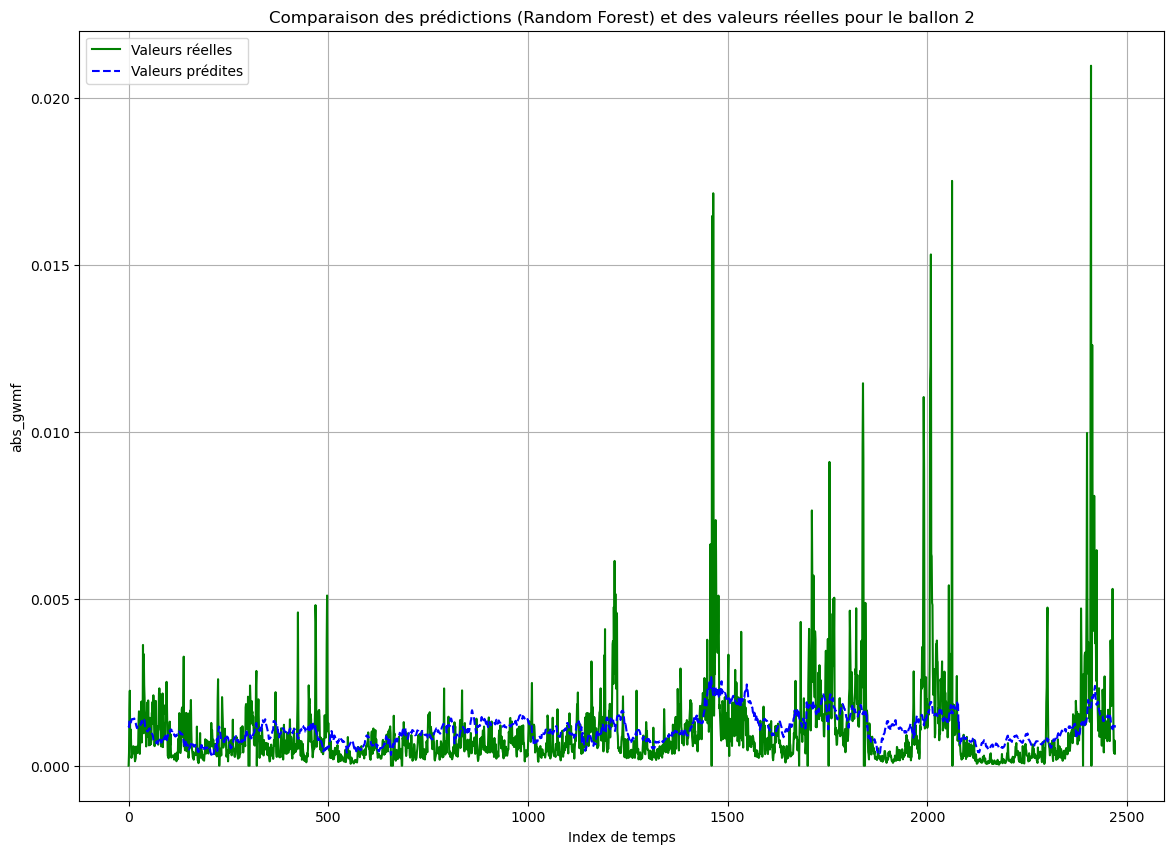

In [188]:
prediction_vs_reel(dict_predictions_lr, 2)

In [150]:
def prediction_vs_reel_partielle(dict_predi, balloon_number, debut, fin):

    df_balloon = df.loc[df['balloon']==balloon_number].reset_index()
    df_predi = pd.DataFrame(dict_predi[balloon_number])
    
    # Tracer la série temporelle des valeurs prédites et réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    
    plt.plot(df_balloon['abs_gwmf'].iloc[debut:fin], label='Valeurs réelles', linestyle='-', color='green')
    
    plt.plot(df_predi.iloc[debut:fin], label='Valeurs prédites', linestyle='--', color='blue')
    
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    
    plt.title(f'Comparaison des prédictions (Random Forest) et des valeurs réelles pour le ballon {balloon_number}')
    
    plt.legend()
    plt.grid(True)
    plt.show()

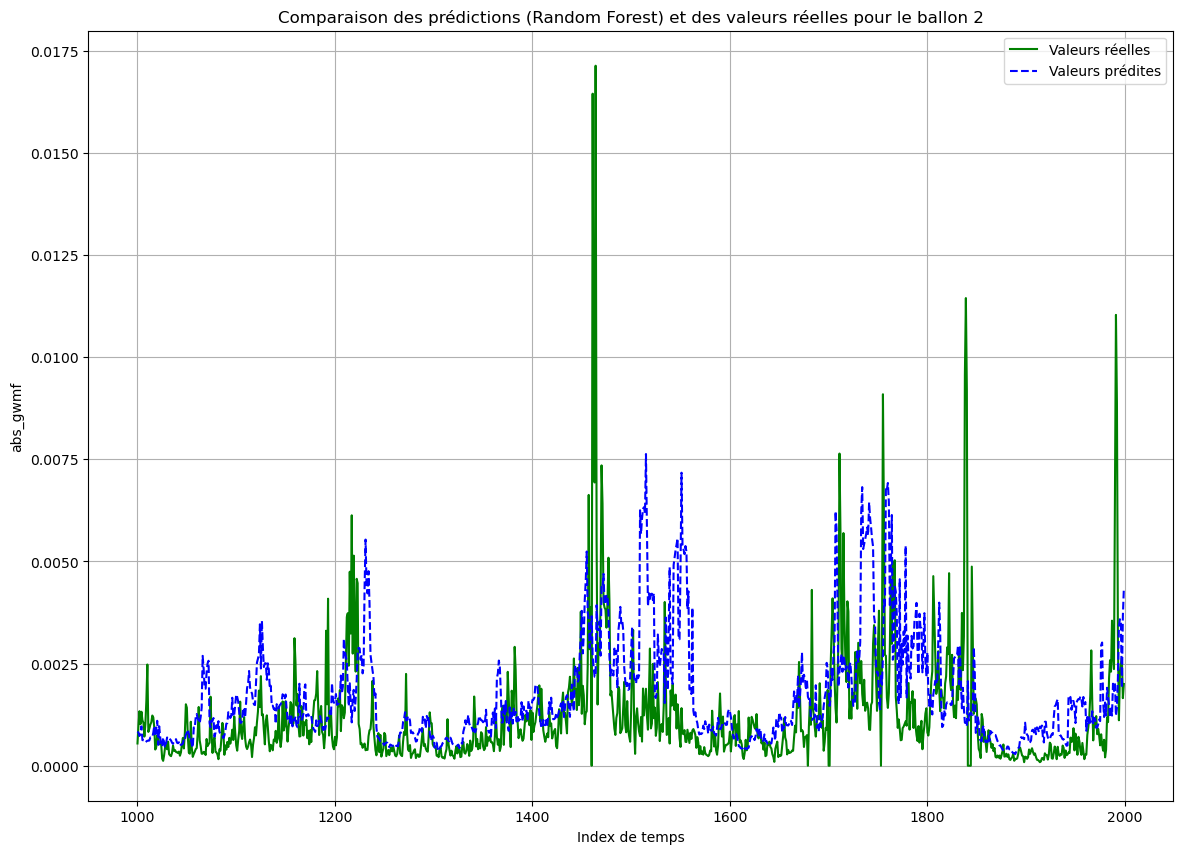

In [152]:
prediction_vs_reel_partielle(predictions_rf, 2, 1000, 2000)

In [178]:
def prediction_vs_reel_partielle_plusieurs_modèles(dict_modèles, balloon_number, debut, fin):

    df_balloon = df.loc[df['balloon']==balloon_number].reset_index()
    
    # Tracer la série temporelle des valeurs réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    plt.plot(df_balloon['abs_gwmf'].iloc[debut:fin], label='Valeurs réelles', linestyle='-', color='green')

    for modele in dict_modèles.keys():
        predi = dict_modèles[modele]
        predi = pd.DataFrame(predi[balloon_number])
        plt.plot(predi.iloc[debut:fin], label=f'Valeurs prédites par le modèle : {modele}', linestyle='--')
    
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    
    plt.title(f'Comparaison des prédictions et des valeurs réelles pour le ballon {balloon_number}')
    
    plt.legend()
    plt.grid(True)
    plt.show()

In [212]:
dict_modèles_1 = {'RandomForest':dict_predictions_rf, 'Linéaire':dict_predictions_lr}

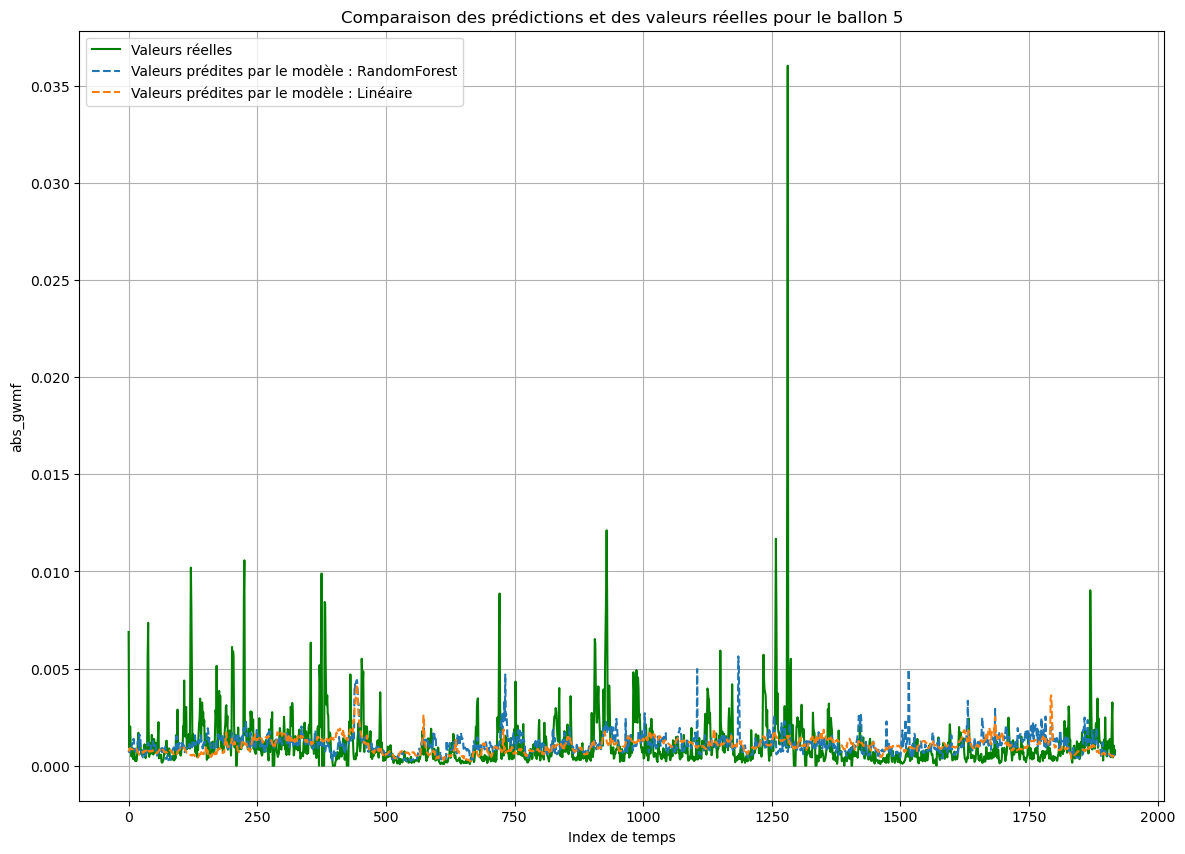

In [213]:
prediction_vs_reel_partielle_plusieurs_modèles(dict_modèles_1, 5, 0, 2500)

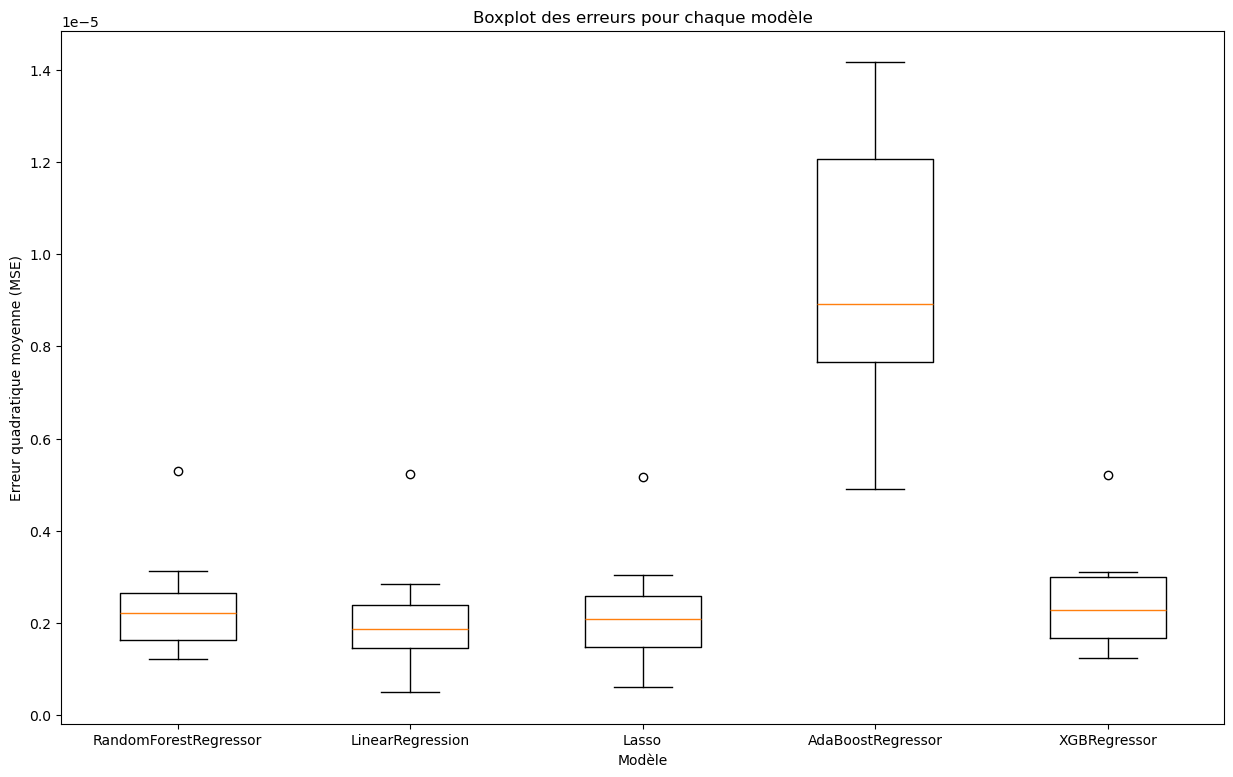

In [190]:
"""BOXPLOT DES ERREURS"""
liste_erreurs = [list_errors_rf, list_errors_lr, list_errors_lasso, list_errors_adaboost, list_errors_xgb]
liste_noms_modèles = ['RandomForestRegressor', 'LinearRegression', 'Lasso', 'AdaBoostRegressor', 'XGBRegressor']

# Création du boxplot
plt.figure(figsize=(15, 9))
plt.boxplot(liste_erreurs, labels=liste_noms_modèles)
plt.title('Boxplot des erreurs pour chaque modèle')
plt.xlabel('Modèle')
plt.ylabel('Erreur quadratique moyenne (MSE)')
plt.show()

In [214]:
"""Corrélations"""

dict_modèles = {'RandomForest':dict_predictions_rf, 'Linéaire':dict_predictions_lr, 'XGB':dict_predictions_xgb}

dict_corr = {'RandomForest':[], 'Linéaire':[], 'XGB':[]}


for balloon in range(1, 9):
    df_balloon = df.loc[df['balloon'] == balloon].reset_index()

    for modele in dict_modèles.keys():
        predi = dict_modèles[modele]
        predi = pd.DataFrame(predi[balloon])
        correlation = df_balloon['abs_gwmf'].corr(predi.squeeze())
        dict_corr[modele].append(correlation)

In [215]:
df_corr = pd.DataFrame(dict_corr)

In [216]:
df_corr

,RandomForest,Linéaire,XGB
0,0.190218,0.243898,0.200279
1,0.317860,0.429785,0.289807
2,0.050044,0.061169,0.095722
3,0.152682,0.086486,0.108329
4,0.083948,0.108004,0.168326
5,0.166937,0.349754,0.144634
6,0.212426,0.242981,0.224610
7,0.402531,0.414256,0.338160


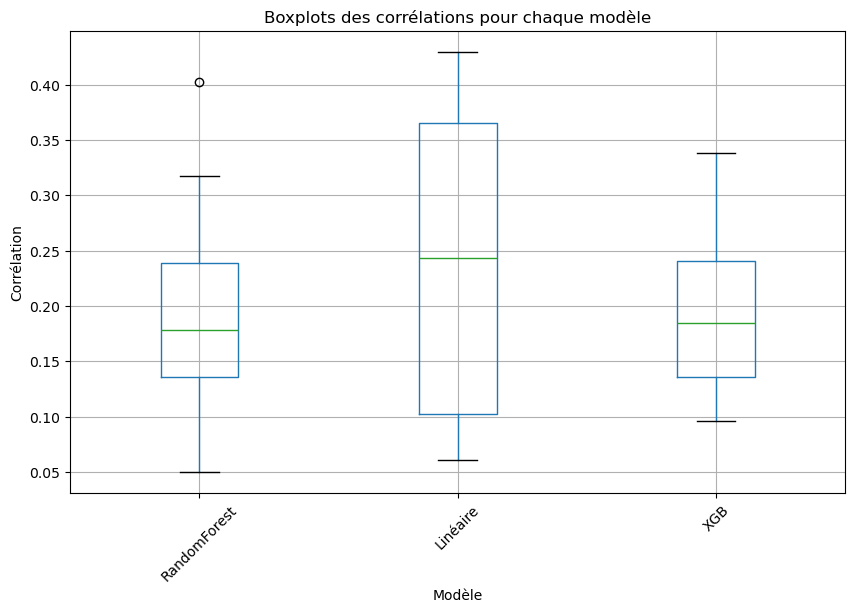

In [217]:
# Tracer les boxplots pour chaque colonne de df_corr
plt.figure(figsize=(10, 6))
df_corr.boxplot()
plt.title('Boxplots des corrélations pour chaque modèle')
plt.xlabel('Modèle')
plt.ylabel('Corrélation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()